In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import folium
from geopy.distance import geodesic
from pyproj import Geod
import numpy as np
from shapely.wkt import loads
from geopy.distance import geodesic
from shapely.geometry import Point, Polygon
from sqlalchemy import create_engine
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd
import importlib
from pyproj import CRS, Transformer
from scipy.integrate import quad
from scipy.integrate import cumtrapz


from pyproj import Geod
from sklearn.metrics import mean_squared_error
geod = Geod(ellps="WGS84")
from shapely.ops import nearest_points
from geopy.distance import geodesic
import mplleaflet
import seaborn as sns
from shapely.wkt import loads

In [2]:
import sys
import os
# Defina o caminho do diretório manualmente
module_path = os.path.abspath(os.path.join('..', 'modules'))

# Adicione o diretório ao sys.path
sys.path.append(module_path)
from calculate_mean_speed_modules import *


from predict_modules import *


In [3]:
# Função para reconstruir a trajetória
def get_routes(conn):
    query = f"""
    SELECT
        linha,
        week_day,
        ST_AsText(start_point) as start_point,
        ST_AsText(end_point) as end_point,
        ST_AsText(route_line_out) as route_line_out,
        ST_AsText(route_line_back) as route_line_back
    FROM public.bus_routes
    """
    
    # Carregar dados em um GeoDataFrame
    df = pd.read_sql(query, conn)

    return df

# Função trazer os dados de um onibus
def get_bus_train_data_datahora(conn, linha):
    # Selecionar dados da tabela bus_routes para a linha específica
    query = f'''select
                a.*,
                b.latitude as latitude_resposta,
                b.longitude as longitude_resposta,
                b.filename as filename_resposta
                from public.vehicle_tracking_treino_datahora a left join 
                public.vehicle_tracking_treino_latlong_resposta b on 
                (a.id = b.id and split_part(a.filename, 'treino-', 2) = split_part(b.filename, 'resposta-', 2))
                where
                linha = '{linha}'
            '''
        
    # Carregar dados em um GeoDataFrame
    df = pd.read_sql(query, conn)

    return df


# Função trazer os dados de um onibus
def get_bus_train_data_latlong(conn, linha):
    # Selecionar dados da tabela bus_routes para a linha específica
    query = f'''select
                a.*,
                     b.datahora_epoch as datahora_epoch_resposta,
                     b.filename as filename_resposta
                from public.vehicle_tracking_treino_latlong a left join 
                public.vehicle_tracking_treino_datahora_resposta b on (a.id = b.id  and split_part(a.filename, 'treino-', 2) = split_part(b.filename, 'resposta-', 2))
                where
                linha = '{linha}'
            '''
        
    # Carregar dados em um GeoDataFrame
    gdf = gpd.read_postgis(query, conn, geom_col='geom', crs='EPSG:4326')

    return gdf

def get_bus_train_data(conn, linha):
    query = f'''select 
                    *, 
                    ST_Transform(geom::geometry, 4326) AS geometry 
                from vehicle_tracking_treino_base where 
                linha = '{linha}'
            '''
        
    # Carregar dados em um GeoDataFrame
    gdf = gpd.read_postgis(query, conn, geom_col='geometry', crs='EPSG:4326')

    return gdf


def get_speed_model(conn, linha):
    query = f'''select 
                    *
                from bus_speed_model where 
                linha = '{linha}'
            '''
        
    # Carregar dados em um GeoDataFrame
    df = pd.read_sql(query, conn)

    return df


## Test speed model for 606

#### Import 606 data from database

In [4]:

# Conectar ao banco de dados PostgreSQL
conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)



routes = get_routes(conn)
bus_speed_df = get_speed_model(conn, '606')
bus_data_latlong = get_bus_train_data_latlong(conn, '606')
bus_data_datahora = get_bus_train_data_datahora(conn, '606')
bus_data_train = get_bus_train_data(conn, '606')
conn.close()

In [5]:
bus_data_train['datahora'] = pd.to_datetime(bus_data_train['datahora'])
bus_data_train = gpd.GeoDataFrame(bus_data_train, geometry='geometry', crs="EPSG:4326")

- transform train data

In [6]:
data = bus_data_latlong['filename'].str.split('-', expand=True)

data = data[1] + data[2] + data[3].str[:-5] + '00'

bus_data_latlong['filename_data'] = pd.to_datetime(data, format='%Y%m%d_%H%M')

- Transform lat long data

In [7]:
data = bus_data_datahora['filename'].str.split('-', expand=True)

data = data[1] + data[2] + data[3].str[:-5] + '00'

bus_data_datahora['filename_data'] = pd.to_datetime(data, format='%Y%m%d_%H%M')
bus_data_datahora['point_resposta'] = bus_data_datahora.apply(lambda x: Point(x['longitude_resposta'], x['latitude_resposta']), axis=1)

bus_data_datahora = gpd.GeoDataFrame(bus_data_datahora, geometry='point_resposta', crs="EPSG:4326")

- Transform datahora data

In [8]:
routes['route_line_out'] = routes['route_line_out'].map(lambda x: loads(x))
routes['route_line_back'] = routes['route_line_back'].map(lambda x: loads(x))
routes['end_point'] = routes['end_point'].map(lambda x: loads(x))
routes['start_point'] = routes['start_point'].map(lambda x: loads(x))


routes_gdf = gpd.GeoDataFrame(routes, geometry='start_point', crs="EPSG:4326")
routes.head()

,linha,week_day,start_point,end_point,route_line_out,route_line_back
0,3,Segunda,POINT (-43.495039457092815 -22.883836915499124),POINT (-43.49507423162255 -22.884352563230294),LINESTRING (-43.495039457092815 -22.8838369154...,LINESTRING (-43.495039457092815 -22.8838369154...
1,774,Segunda,POINT (-43.32742040832666 -22.807352655457702),POINT (-43.341946615320566 -22.870417119067444),LINESTRING (-43.32742040832666 -22.80735265545...,LINESTRING (-43.341946615320566 -22.8704171190...
2,864,Segunda,POINT (-43.46365464290197 -22.876013326220658),POINT (-43.55592869637883 -22.901696375116064),LINESTRING (-43.46365464290197 -22.87601332622...,LINESTRING (-43.55592869637883 -22.90169637511...
3,852,Domingo,POINT (-43.64163358974359 -23.00088102564103),POINT (-43.554660550458706 -22.90174194954129),LINESTRING (-43.64163358974359 -23.00088102564...,LINESTRING (-43.554660550458706 -22.9017419495...
4,483,Segunda,POINT (-43.28434311311084 -22.836897800432855),POINT (-43.19716470131702 -22.98572288570085),LINESTRING (-43.28434311311084 -22.83689780043...,LINESTRING (-43.19716470131702 -22.98572288570...


- Transform routes data

## Try to predict one bus time passed

#### Evaluate results for one bus

In [100]:
filename = 'treino-2024-05-14_09.json'
ordem = bus_data_latlong.loc[bus_data_latlong['filename'] == filename, 'ordem'].unique()[6]

In [101]:
ordem

'B25594'

In [102]:
pred_time = PredictTime()

In [103]:
pred_latlong = pred_time.predict_epoch(filename, ordem, routes_gdf, bus_speed_df, bus_data_latlong, bus_data_train, '606')

In [109]:
mse = mean_squared_error(pred_latlong['datahora_epoch_resposta'], pred_latlong['datahora_epoch_actual'] )

rmse = np.sqrt(mse)
print(f'RMSE {ordem} (606) for file {filename}', rmse/1000/60)

RMSE B25594 (606) for file treino-2024-05-14_09.json 10.038519960385731


Text(0.5, 1.0, 'Time difference in minutes for each prediction \n B25594 (606) for file treino-2024-05-14_09.json')

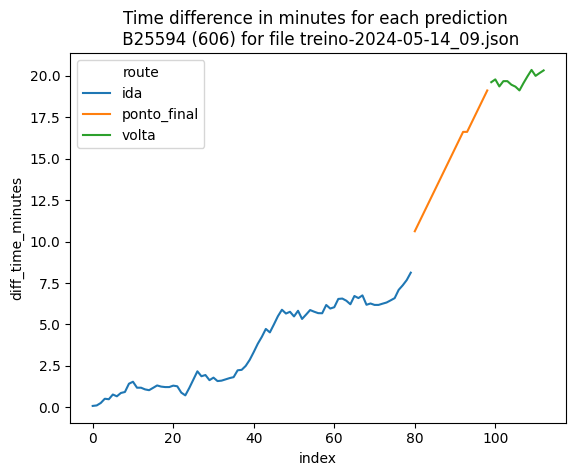

In [110]:
pred_latlong['diff_time_minutes'] = (pred_latlong['datahora_epoch_resposta'] - pred_latlong['datahora_epoch_actual'])/1000/60
pred_latlong = pred_latlong.reset_index()
sns.lineplot(pred_latlong, y='diff_time_minutes', x='index', hue='route')
plt.title(f'Time difference in minutes for each prediction \n {ordem} (606) for file {filename}')

- RMSE of 10 minutes for one bus in one file (606)
- During the end points the difference just increases because we do not know when the bus will leave the end point

In [111]:
pred_latlong_handle = pred_time.predict_epoch(filename, ordem, routes_gdf, bus_speed_df, bus_data_latlong, bus_data_train, '606', handle_end=True)

In [112]:
pred_latlong_handle

,id_actual,ordem_actual,datahora_epoch_actual,datahora_epoch_resposta,filename,route
0,1392,B25594,1.715684e+12,1715684425000,treino-2024-05-14_09.json,ida
1,2806,B25594,1.715684e+12,1715684455000,treino-2024-05-14_09.json,ida
2,4290,B25594,1.715684e+12,1715684485000,treino-2024-05-14_09.json,ida
3,5788,B25594,1.715684e+12,1715684515000,treino-2024-05-14_09.json,ida
4,7130,B25594,1.715685e+12,1715684545000,treino-2024-05-14_09.json,ida
...,...,...,...,...,...,...
108,158751,B25594,1.715687e+12,1715687845000,treino-2024-05-14_09.json,volta
109,160129,B25594,1.715687e+12,1715687875000,treino-2024-05-14_09.json,volta
110,161619,B25594,1.715687e+12,1715687905000,treino-2024-05-14_09.json,volta
111,163157,B25594,1.715687e+12,1715687935000,treino-2024-05-14_09.json,volta


In [113]:
mse = mean_squared_error(pred_latlong_handle['datahora_epoch_resposta'], pred_latlong_handle['datahora_epoch_actual'] )

rmse = np.sqrt(mse)
print(f'RMSE {ordem} (606) for file {filename}', rmse/1000/60)

RMSE B25594 (606) for file treino-2024-05-14_09.json 7.683878109317571


Text(0.5, 1.0, 'Time difference in minutes for each prediction \n B25594 (606) for file treino-2024-05-14_09.json')

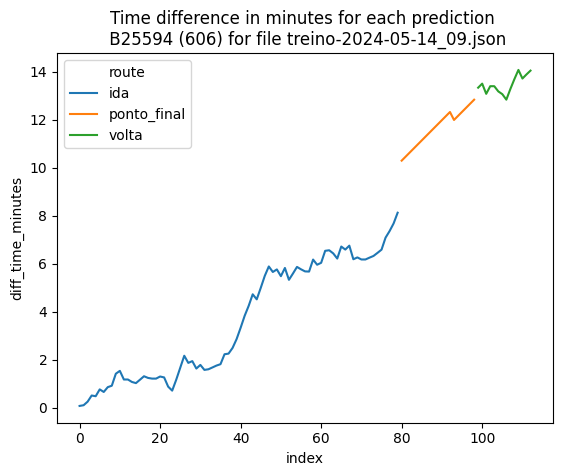

In [82]:
pred_latlong_handle['diff_time_minutes'] = (pred_latlong_handle['datahora_epoch_resposta'] - pred_latlong_handle['datahora_epoch_actual'])/1000/60
pred_latlong_handle = pred_latlong_handle.reset_index()

sns.lineplot(pred_latlong_handle, y='diff_time_minutes', x='index', hue='route')
plt.title(f'Time difference in minutes for each prediction \n {ordem} (606) for file {filename}')

- Using the median of the time passed in the end points the results got better

## Try to predict one bus lat long

In [83]:
filename = 'treino-2024-05-11_13.json'
ordem = bus_data_datahora.loc[bus_data_datahora['filename'] == filename, 'ordem'].unique()[5]

In [84]:
day_of_week = bus_data_datahora.loc[bus_data_datahora['filename'] == filename, 'filename_data'].dt.day_name().iloc[0]
day = bus_data_datahora.loc[bus_data_datahora['filename'] == filename, 'filename_data'].dt.day.iloc[0]

In [85]:
pred = PredictLatLong()

In [86]:
pred_datahora = pred.predict_lat_long(filename, ordem, routes_gdf, bus_speed_df, bus_data_datahora, bus_data_train, '606', handle_end=False)

In [87]:
mse = mean_squared_error(pred_datahora[['latitude_resposta', 'longitude_resposta']], pred_datahora[['latitude_actual', 'longitude_actual']] )

rmse = np.sqrt(mse)
print(f'RMSE {ordem} (606) for file {filename}', rmse)

RMSE B25542 (606) for file treino-2024-05-11_13.json 0.029483541447651095


Text(0.5, 1.0, 'Difference latitude in minutes for each prediction \n B25542 (606) for file treino-2024-05-11_13.json')

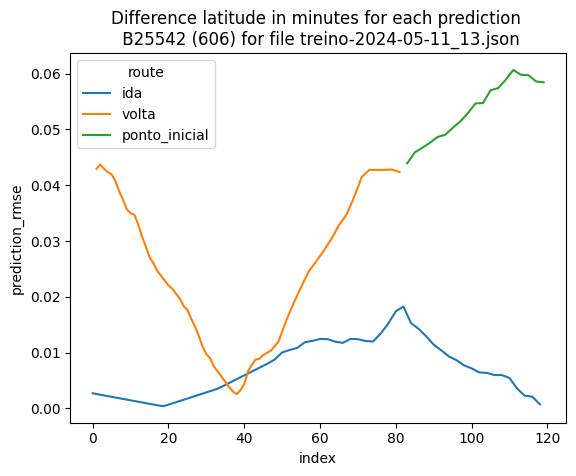

In [88]:
rmse_values = []

for i in range(len(pred_datahora)):
    mse = mean_squared_error(pred_datahora.loc[i, ['latitude_resposta', 'longitude_resposta']], pred_datahora.loc[i, ['latitude_actual', 'longitude_actual']])
    rmse = np.sqrt(mse)
    rmse_values.append(rmse)


pred_datahora['prediction_rmse'] = rmse_values
pred_datahora = pred_datahora.reset_index()
sns.lineplot(pred_datahora, y='prediction_rmse', x='index', hue='route')
plt.title(f'Difference latitude in minutes for each prediction \n {ordem} (606) for file {filename}')

- In this model is difficult to know in what route the bus is, because we only have the reference from two hours before to start in an specific route, and along the trajectory the bus can change routes